### Klaviyo Exercise
In order to remove bias, we have anonymized this step of the interview process. 

 * **Please do not deanonymize yourself in this jupyter notebook**.
 * **Please write your code and solutions in this notebook and return it to us when you are finished**.

### Interpreting the Dataset
In these exercises, you will work with sales data from a marketplace with several stores.  The attached CSV file lists the customer, date, and dollar value of orders placed in 2017. Assume that there is only one product in each order. The store ID and product ID are also included for each ordered product. The gender of each customer is also provided. Please do not exclude $0 orders.

### Exercise 1
Assemble a dataframe with one row per customer and the following columns:
* customer_id 
* gender
* most_recent_order_date 
* order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

In [1]:
# Importing modules and data
import pandas as pd
import numpy as np

sales = pd.read_csv('screening_exercise_orders_v202101.csv')
sales.head()

,customer_id,gender,date,product_value,store_id,product_id,product_is_red
0,1000,0,2017-01-01 00:11:31,72.346503,5,516,True
1,1001,0,2017-01-01 00:29:56,326.006005,2,287,False
2,1002,1,2017-01-01 01:30:31,420.453635,4,450,False
3,1003,1,2017-01-01 01:34:22,377.703064,0,81,True
4,1004,0,2017-01-01 03:11:54,35.620216,7,743,False


In [2]:
# Grouping data by customer id and counting sales volume
customers = sales.groupby('customer_id')['date'].count()
customers =  customers.to_frame().rename(columns = {'date':'order_count'})

In [3]:
# Grouping data by customer id and last sale date
last_order = sales.groupby('customer_id')['date'].max()
last_order = last_order.to_frame().rename(columns = {'date':'most_recent_order_date'})

In [4]:
# Joinging data into one dataframe
customers = customers.join(last_order)
customers = pd.merge(customers,sales,on='customer_id',how='left')
customers = customers.drop(['date', 'product_value', 'store_id','product_id', 'product_is_red'], axis=1)

# Reordering the dataframe
customers = customers[['customer_id','gender','most_recent_order_date','order_count']].set_index('customer_id')

# Display results
customers.head(10)

,gender,most_recent_order_date,order_count
customer_id,,,
1000,0,2017-01-01 00:11:31,1
1001,0,2017-01-01 00:29:56,1
1002,1,2017-02-19 21:35:31,3
1002,1,2017-02-19 21:35:31,3
1002,1,2017-02-19 21:35:31,3
1003,1,2017-04-26 02:37:20,4
1003,1,2017-04-26 02:37:20,4
1003,1,2017-04-26 02:37:20,4
1003,1,2017-04-26 02:37:20,4


### Exercise 2
Plot the total order count for the marketplace by week. Do not use plotly, as plotly graphs in Jupyter Notebooks don't render correctly on different machines.

In [5]:
# Importing packages
import matplotlib.pyplot as plt

In [6]:
# Converting date column to datetimeindex
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.set_index('date')

In [7]:
# Resample timeseries data -- counting customer id's just counts how many rows (orders), not unique id's
weekly_resample = sales.resample('7D').count()['customer_id']

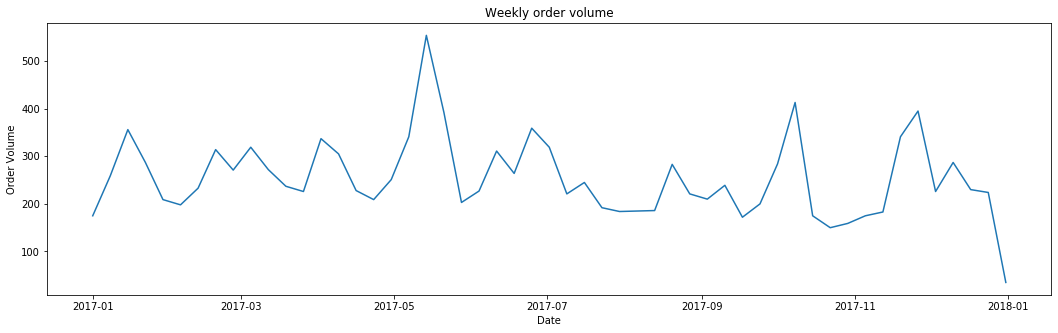

In [26]:
# Creating Visual
plt.figure(figsize=(18, 5))
plt.plot(weekly_resample)
plt.title('Weekly order volume')
plt.xlabel('Date')
plt.ylabel('Order Volume')
plt.show()

### Exercise 3

Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? 

**Justify your choice of method and state any assumptions you make**.

# Approach and assumptions

As the samples are not normally distributed, and there is only one sample of orders for each population, I will also create bootstrap replicates of the mean order values for each population. This will create a set of normally distributed sample statistics. By mean shifting the samples, the set of sample statistics will have mean zero. 

We then test the hypothesis <br>
Ho: gender_1 mean - gender_0 mean = 0 <br>
Ha: gender_1 mean - gender_0 mean > 0 

If our bootstrapped replicates create a p-value of less than 0.05, we will have confidence at 95% that the difference in means observed is statistically significant. 

Since the samples are large, I will also run a two-sample z-test to see if results are different from the bootstrap approach. 


In [9]:
# Separate populations
gender_0_orders = sales.product_value[sales.gender==0]
gender_1_orders = sales.product_value[sales.gender==1]

# Mean/std order value gender 0
gen_0 = gender_0_orders.mean()
std_0 = gender_0_orders.std()
print('Gender 0 mean: '+ str(gen_0) + ' on ' + str(len(sales.product_value[sales.gender==0])) + ' orders')

# Mean/std order value gender 1
gen_1 = gender_1_orders.mean()
std_1 = gender_1_orders.std()
print('Gender 1 mean: '+str(gen_1) + ' on ' + str(len(sales.product_value[sales.gender==1])) + ' orders')

Gender 0 mean: 446.42790647964915 on 6759 orders
Gender 1 mean: 462.59273386174374 on 6712 orders


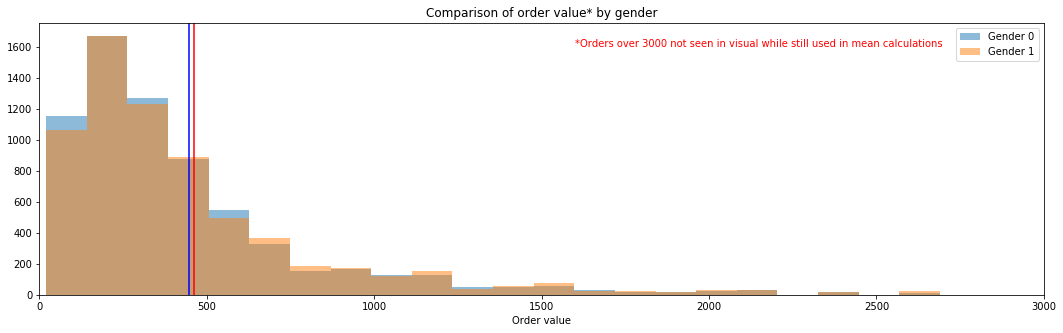

In [25]:
# Create histogram containing both populations
plt.figure(figsize=(18, 5))


plt.hist(gender_0_orders, bins=40, alpha=0.5, label='Gender 0')
plt.hist(gender_1_orders, bins=40, alpha=0.5, label='Gender 1')
plt.axvline(gen_0 ,color='b')
plt.axvline(gen_1 ,color='r')
plt.legend()
plt.xlim(xmin=0, xmax = 3000)
plt.xlabel('Order value')
plt.title('Comparison of order value* by gender')
plt.text(1600, 1600, '*Orders over 3000 not seen in visual while still used in mean calculations',
        color='red', fontsize=10)
plt.show()

In [11]:
# Bootstrapping tools

np.random.seed(47)
N_rep = 10000

def bootstrap_replicate_1d(data, func):
    """Generate single bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def create_bs_reps_array(data, func, size=1):
    """Creates an array of size input creating bootstrap replicates of function statistic."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [12]:
# Creating mean shifted charges arrays
gender_0_orders = sales.product_value[sales.gender==0]
gender_1_orders = sales.product_value[sales.gender==1]

gen_0_mean = sales.product_value[sales.gender==0].mean()
gen_1_mean = sales.product_value[sales.gender==1].mean()
combined_mean = sales.product_value.mean()

gen_0_shifted = gender_0_orders - gen_0_mean + combined_mean
gen_1_shifted = gender_1_orders - gen_1_mean + combined_mean

# Creating bootstrap samples
bs_gen_0_mean = create_bs_reps_array(gen_0_shifted, np.mean, size=10000)
bs_gen_1_mean = create_bs_reps_array(gen_1_shifted, np.mean, size=10000)

# Bootstraped replicates of difference of means
bs_difference = bs_gen_1_mean - bs_gen_0_mean

# Find probablity of events at least as extreme as observed
p = np.sum(bs_difference >= gen_1_mean-gen_0_mean) / len(bs_difference)
print('p-value =', p)

p-value = 0.0254


# 2 sample bootstrap replicates conclusion

With only 2.18% of samples creating a mean difference at least as extreme as observed, we can reject the null hypothesis that the population means are equal and establish that the difference observed is statistically significant. 

In [13]:
# 2 sample z test
z = (gen_1_mean-gen_0_mean)/np.sqrt(std_1**2/len(gender_1_orders)+std_0**2/len(gender_0_orders))
z

1.9722929726833616

# 2 sample Z-test conclusion
A z-score of 1.99 > 1.65. The null hypothesis is rejected at a significance level of 0.05.

### Exercise 4

Suppose that some of our customers told us that they believe red products are more eye-catching and therefore easier to sell. Based on the dataset provided, would you suggest that companies should color more of their products red? Why or why not and what other factors could be important to determine this? 

**Please justify your answer and state any assumptions you make.**

# Assumptions and approach

"Easier to sell" first needs a quantitative definition. My interpretation is that easier to sell will translate to a higher volume of sales of red products than non-red products. Price of the item will be ignored, although it is acknowledged that product price can directly affect an item's ability to sell. 

If the red items were exactly as easy to sell as a non-red item, we could assume that each population would get 50% of the sales. With 13471 items sold, we would expect 6735.5 of each. 

I will calculate a chi-squared test statistic comparing the observed and expected frequencies. 

Null Hypothesis: The proportions of red and not-red items are equal. 
Alternative Hypothesis: At least one of the proportions are not equal to the predicted model (i.e. the proportions are not equal since there are only two categories)

In [14]:
red_orders = sales.groupby('product_is_red').agg({'product_value':np.mean,"product_id":'count'})
red_orders.columns = ['average_value','frequency']

In [15]:
red_orders

,average_value,frequency
product_is_red,,
False,437.911450,5904
True,467.411055,7567


In [16]:
from scipy.stats import chisquare

# scipy.stats.chisquare assumes equal proportions unless provided with different. 50/50 is what we are running
chi_squared, p = chisquare(red_orders.frequency)

In [17]:
chi_squared

205.29797342439315

In [18]:
p

1.45803837841609e-46

In [19]:
# Observed proportions
red_orders.frequency/len(sales)

product_is_red
False    0.438275
True     0.561725
Name: frequency, dtype: float64

# Chi-Square conclusion

If the observed and expected frequencies would have been equal, the chi-squared would have been zero. As the p-value for this test was much lower than any alpha, we can successfully conclude that the proportion of red/not-red products is not 50/50 and the true proportion of red items sold is closer to the 56% observed, making the red items more likely to sell than the non-red items. 

### Exercise 5

Describe one of your favorite tools or techniques and give a small example of how it has helped you solve a problem. Limit your answer to one short paragraph, and please be specific. 

I think the Pandas dataframe is one of my favorite tools. As someone who has done a good amount of programming before, I was new to Python around November 2019. The dataframe has been a joy to work with, as there is something satisfying about vectorizing process instead of writing loops to modify specific data entries based on conditionals. 

Recently, I had a time series dataframe where each entry was a mission for a robot. Not all entries were for the same robot, and I was trying to calculate an average time between missions. Since the time delta was only relevant if the robotID was the same from row to row, but also the missionID had to be adjacent, I had to do more than just calculate the time delta in for each row. In the past, I would have looped, and checked each robotID and missionID with conditionals, and only recorded the time delta if the conditionals passed. 

The process of creating the masks allowed me to update the time delta, only for those rows that met the each conditional, without running a loop. 

I was personally excited about this method, as I have been personally battling with "SettingWithCopy" warnings in some scenarios similar to this, but the masking approach solved my issue there. 

In [ ]:
"""This code will not run, it is merely ment to show my example"""


# A filter for making sure consecutive rows refer to same robot
filter1 = mission['robotid'] == mission['robotid'].shift()

# A filter for making sure consecutive rows are consecutive mission numbers
filter2 = mission.nmssn == (mission.nmssn.shift()+1)

# Applying the filters to the time_delta data, creating minutes since last mission (mission start to mission start)
mission.IMI.mask(filter1 & filter2, other = mission.delta, inplace=True)